# MAC0318 - Arquiteturas sensorimotoras - Notebook 1

*Pré-requisitos*: 
- **Software**: Para rodar este notebook corretamente, você deve ter o Python na versão 3.9 ou mais recente e as bibliotecas NumPy e OpenCV. Antes de começar, assegure-se de que essas condições são satisfeitas.
- **Conhecimento**: Esta atividade assume familiaridade com o uso de notebooks Jupyter, a manipulação de matrizes usando a bilbioteca NumPy e a representação de imagens digitais coloridas em matrizes. Recomendamos seguir algum tutorial da internet antes de realizar essa atividade, se esse não for o seu caso.

<span style="color:blue">Se você está rodando o notebook em sala de aula, você deve ativar o ambiente `duckievillage` antes de abrir o jupyter notebook e escolher o kernel `duckievillage`, para que os requerimentos sejam satisfeitos.</red>

## Processamento de imagem

Este tutorial ensina a implementar um simples filtro por cores em imagem, que será usado para implementar agentes reativos seguindo a arquitetura proposta por Braitenberg.

In [17]:
# Vamos primeiro carregar os módulo necessários
# para mostrar imagens no notebook:
%matplotlib inline
from pylab import imshow
from matplotlib import pyplot as plt
# para maninpulação de matrizes (numpy):
import numpy as np
from numpy import uint8
# e para manipulação de imagens (opencv):
import cv2

In [18]:
# Agora vamos carregar uma imagem de arquivo em formato PNG como um vetor multidimensional
img = cv2.imread('img/sim1.png') # devolve vetor multidimensional do numpy 
print(type(img), img.dtype) # OpenCV representa pixels comom 8 bits sem sinal

<class 'numpy.ndarray'> uint8


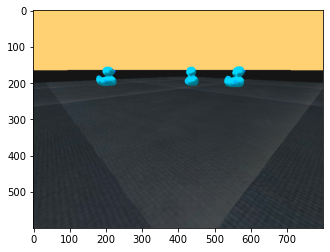

In [19]:
# Podemos visualizar a imagem representada pela matriz 
# usando o comando abaixo (do matplotlib)
imshow(img); # Exibe uma matriz RGB como imagem (abaixo)
# Note que as coordenadas das ordenadas (eixo-y) crescem no sentido para baixo
# Essa é a convenção mais comum para representação de imagens

In [20]:
# A imagem acima está colorida de forma estranha.
# Isso é porque o OpenCV usa o formato BGR para os canais de cores em vez de RGB.
# Vamos consertar isso, manipulando as dimensões do vetor numpy:
img = img[:,:,::-1] # Transforma canais BGR em RGB
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # alternativa usando função do OpenCV

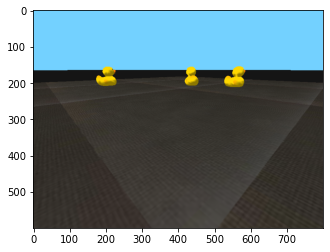

In [21]:
# Agora podemos exibir a imagem corretamente
imshow(img); # Exibe uma matriz RGB como imagem (abaixo)
# Mas lembre-se: o OpenCV espera imagens coloridas em formato BGR

## Representação de imagens

Imagens são comumente representadas digitalmente como vetores multidimensionais no espaço $\mathbb{R}^{M \times N \times 3}$ chamado de RGB, no qual $M$ é o número de linhas, $N$ é o número de colunas e as 3 dimensões restante representam os valores de intensidade das cores vermelha (R), verde (G) e azul (B) de cada ponto na imagem (_pixel_). Também é comum a representação com uma quarta dimensão indicando a transparência de cada ponto (RGBA).

In [22]:
# Dimensões da imagem em RGBA no exemplo acima
img.shape

(600, 799, 3)

In [23]:
# Para obtermos um corte da imagem, basta extrairmor um sub-vetor
corte = img[0:3,0:6,:] # copia retângulo 6x3 no canto esquero superior

In [24]:
# Amostra do vetor
print(corte)

[[[115 209 255]
  [115 209 255]
  [115 209 255]
  [115 209 255]
  [115 209 255]
  [115 209 255]]

 [[115 209 255]
  [115 209 255]
  [115 209 255]
  [115 209 255]
  [115 209 255]
  [115 209 255]]

 [[115 209 255]
  [115 209 255]
  [115 209 255]
  [115 209 255]
  [115 209 255]
  [115 209 255]]]


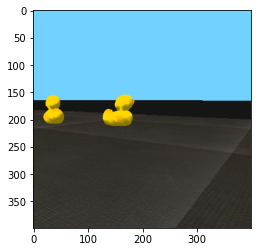

In [25]:
# Vamos extrair um corte mais interessante e exibí-lo:
corte = img[:img.shape[1]//2,img.shape[1]//2:,:] # Copia retângulo no canto direito superior
imshow(corte);

## Representação em RGB

Os pontos no espaço RGB indicam a intensidade da luz após ser submetida a três filtros ideais independentes (vermelho, azul e verde).
Dessa forma, algumas propriedades esperadas da manipulação de cores que observamos (como combinar tintas no papel) não são satisfeitas. 
Em particular, tal representação é incoveniente quando desejamos segmentar os pontos de acordo com uma cor, ou seja, quando queremos selecionar variações de uma cor introduzidas por diferenças na iluminação, superfície dos objetos etc.

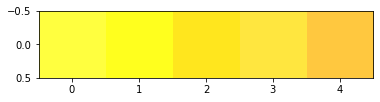

In [26]:
# Exemplo de pontos de "tonalidade" similar, mas representações distantes em RGB
# note como o resultado da modificação de uma coordenada é não trivial
cores_rgb = np.array([[
    [255,255,63], 
    [255,255,30], 
    [255,230,30], 
    [255,230,63], 
    [255,200,63] 
]], dtype=uint8)
imshow(cores_rgb); 

## Espaço HSV

O [espaço HSV](https://en.wikipedia.org/wiki/HSL_and_HSV#Examples) (Hue-Saturation-Value) foi desenvolvido para tornar a manipulação de cores mais intuitiva e próxima da experiência cotidiana (quando mexemos com tintas, por exemplo). Nesse espaço cada ponto é representado pela sua matiz (indicando a proximadade com uma cor), saturação (indicando a vibrância da cor) e valor (indicando a luminosidade).

<figure>
    <div style="text-align: center">
        <img src="img/hsv.png" width="300px">
    </div>
</figure>

Dado um ponto $(R,G,B)$ no espaço RGB, obtemos sua representação $(H,S,V)$ da seguinte forma.
$V=\max(R,G,B)$ é o valor máximo de uma cor no espaço RGB.
Seja $C=V-L$ com $L=\min(R,G,B)$ (esse valor é conhecido como croma), então $S=V/C$ se $C \neq 0$ e $S=0$ caso contrário.
Por fim, a matiz (_hue_) $H$ é obtida projetando o espaço RGB no hiperplano perpendicular ao vértice preto (0,0,0) e introduzindo coordenadas polares:
$$
H = 60 \times \begin{cases} (G-B)/C \mod 6 & \text{se } V = R \\ (B-R)/C + 2 & \text{se } V = G \\ (R-G)/C + 4& \text{se } V = B \end{cases}
$$

O valor $H$ é indefinido se $C=0$ (ou seja, para tons de cinza). 

In [27]:
def hsv(img):
    "Transforma imagem RGB em HSV (de maneira muito ineficiente!)"
    M, N = img.shape[0], img.shape[1]
    H = np.zeros((img.shape[0],img.shape[1],3), dtype=uint8)
    for i in range(M):
        for j in range(N):
            V = max(img[i,j,0],img[i,j,1],img[i,j,2])
            L = min(img[i,j,0],img[i,j,1],img[i,j,2])
            C = V-L
            if V == img[i,j,0]:
                Hp = ((img[i,j,1]-img[i,j,2])/C) % 6
            elif V == img[i,j,1]:
                Hp = (img[i,j,2]-img[i,j,0])/C + 2
            else:
                Hp = (img[i,j,0]-img[i,j,1])/C + 4
            H[i,j,0] = 60*Hp # hue
            H[i,j,1] = V/C
            H[i,j,2] = V
    return H

In [28]:
cores_hsv = hsv(cores_rgb)
print(cores_hsv) # note como os pontos em HSV possuem valores mais próximos e fáceis de interpretar
# alguns pontos são indistinguíveis por conta da representação em inteiros de 8 bits

[[[ 60   1 255]
  [ 60   1 255]
  [ 53   1 255]
  [ 52   1 255]
  [ 42   1 255]]]


## OpenCV

No lugar da função (ineficiente acima), vamos utilizar a função `cvtColor` da biblioteca OpenCV. Diferentemente da fórmula acima, essa função mapeia a matiz (H) no intervalo [0,180], ou seja, os valores são divididos por 2. O intervalo de valores adotados pelo OpenCV para cada dimensão são:

* Hue: [0,180]
* Saturation: [0,255]
* Value: [0,255]

In [29]:
hsv = cv2.cvtColor(np.array(cores_rgb,dtype=uint8), cv2.COLOR_RGB2HSV)
print(hsv) # note que a primeira coordenada possui seus valores dividos por 2 com relação a função hsv

[[[ 30 192 255]
  [ 30 225 255]
  [ 27 225 255]
  [ 26 192 255]
  [ 21 192 255]]]


## Filtro por cor

Podemos utilizar os valores de _hue_ para filtrar os pontos da imagem dentro de uma tonalidade. A função [`inRange`](https://docs.opencv.org/3.4/d2/de8/group__core__array.html#ga48af0ab51e36436c5d04340e036ce981) da biblioteca OpenCV recebe uma imagem e um intervalo no espaço HSV e devolve uma matriz de 0s e 255s contendo os pontos cujos valores no espaço HSV estão na faixa dada. Vamos usar tal filtro para encontrar os patos nas imagens.

In [30]:
# Intervalo para pontos amarelados (H em [5,30]) 
lower_hsv = np.array([5, 100, 100])    
upper_hsv = np.array([30, 255, 255])

In [31]:
# obter representação HSV
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
# Construir máscara dos pontos no hiperretângulo do espaço HSV especificado
mask = cv2.inRange(hsv, lower_hsv, upper_hsv)
print(mask) # matriz de 0s e 255s
print(mask.min(), mask.max())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
0 255


A função [`bitwise_and`](https://docs.opencv.org/3.4/d2/de8/group__core__array.html#ga60b4d04b251ba5eb1392c34425497e14) recebe duas imagens `img1` e `img2` e uma máscara, e devolve a conjunção lógica de bits ponto a ponto das imagens com a máscara

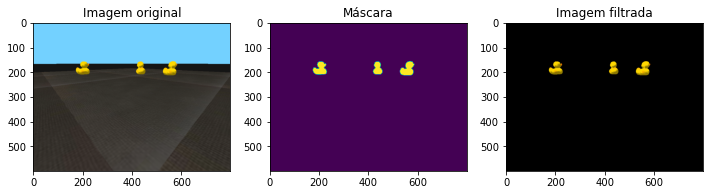

In [44]:
# Aplicar máscara na imagem (representada em RGB)
masked = cv2.bitwise_and(img[:,:,:3], img[:,:,:3], mask=mask)
f, ax = plt.subplots(1,3, figsize=(12,5))
ax[0].imshow(img);
ax[0].set_title('Imagem original');
ax[1].imshow(mask, cmap='gray');
ax[1].set_title('Máscara');
ax[2].imshow(masked[:,:,:3]);
ax[2].set_title('Imagem filtrada');

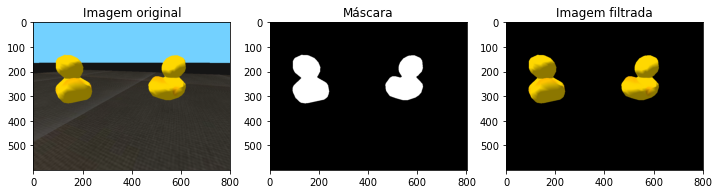

In [33]:
# Exemplo de imagem com patos mais próximos
img_sim = cv2.cvtColor(cv2.imread('img/sim3.png'), cv2.COLOR_BGR2RGB)
hsv_sim = cv2.cvtColor(img_sim, cv2.COLOR_RGB2HSV)
mask_sim = cv2.inRange(hsv_sim, lower_hsv, upper_hsv)
masked_sim = cv2.bitwise_and(img_sim, img_sim, mask=mask_sim)
f, ax = plt.subplots(1,3, figsize=(12,5))
ax[0].imshow(img_sim);
ax[0].set_title('Imagem original');
ax[1].imshow(mask_sim, cmap='gray');
ax[1].set_title('Máscara');
ax[2].imshow(masked_sim);
ax[2].set_title('Imagem filtrada');

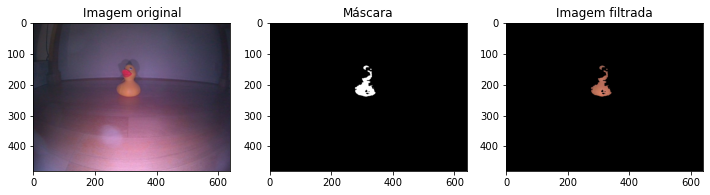

In [34]:
# Vamos carregar uma imagem obtida de uma foto (que introduz uma coloração avermelhada à imagem)
img_real = cv2.cvtColor(cv2.imread('img/oneduck.jpg'), cv2.COLOR_BGR2RGB)
hsv_real = cv2.cvtColor(img_real, cv2.COLOR_RGB2HSV)
mask_real = cv2.inRange(hsv_real, lower_hsv, upper_hsv)
masked_real = cv2.bitwise_and(img_real, img_real, mask=mask_real)
f, ax = plt.subplots(1,3, figsize=(12,5))
ax[0].imshow(img_real);
ax[0].set_title('Imagem original');
ax[1].imshow(mask_real, cmap='gray');
ax[1].set_title('Máscara');
ax[2].imshow(masked_real);
ax[2].set_title('Imagem filtrada');

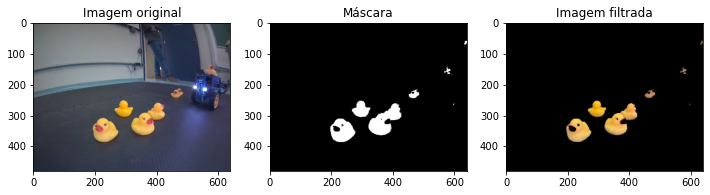

In [35]:
# Outra imagem real (tirada em sala)
img_real = cv2.cvtColor(cv2.imread('img/muitospatos.jpeg'), cv2.COLOR_BGR2RGB)
hsv_real = cv2.cvtColor(img_real, cv2.COLOR_RGB2HSV)
mask_real = cv2.inRange(hsv_real, lower_hsv, upper_hsv)
masked_real = cv2.bitwise_and(img_real, img_real, mask=mask_real)
f, ax = plt.subplots(1,3, figsize=(12,5))
ax[0].imshow(img_real);
ax[0].set_title('Imagem original');
ax[1].imshow(mask_real, cmap='gray');
ax[1].set_title('Máscara');
ax[2].imshow(masked_real);
ax[2].set_title('Imagem filtrada');

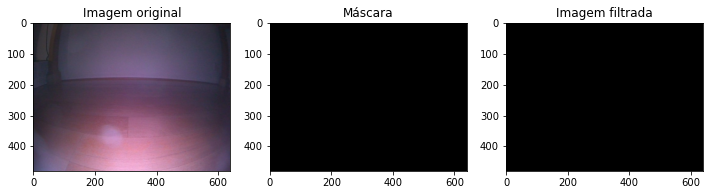

In [36]:
# Uma imagem real sem patos (mascara deveria ser nula)
img_real = cv2.cvtColor(cv2.imread('img/noduckies.jpg'), cv2.COLOR_BGR2RGB)
hsv_real = cv2.cvtColor(img_real, cv2.COLOR_RGB2HSV)
mask_real = cv2.inRange(hsv_real, lower_hsv, upper_hsv)
masked_real = cv2.bitwise_and(img_real, img_real, mask=mask_real)
f, ax = plt.subplots(1,3, figsize=(12,5))
ax[0].imshow(img_real);
ax[0].set_title('Imagem original');
ax[1].imshow(mask_real, cmap='gray');
ax[1].set_title('Máscara');
ax[2].imshow(masked_real);
ax[2].set_title('Imagem filtrada');

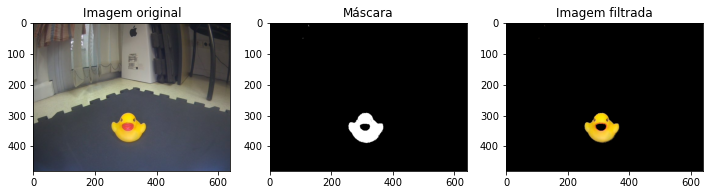

In [37]:
# Mais imagens reais de patos
img_real = cv2.cvtColor(cv2.imread('img/pato1.jpeg'), cv2.COLOR_BGR2RGB)
hsv_real = cv2.cvtColor(img_real, cv2.COLOR_RGB2HSV)
mask_real = cv2.inRange(hsv_real, lower_hsv, upper_hsv)
masked_real = cv2.bitwise_and(img_real, img_real, mask=mask_real)
f, ax = plt.subplots(1,3, figsize=(12,5))
ax[0].imshow(img_real);
ax[0].set_title('Imagem original');
ax[1].imshow(mask_real, cmap='gray');
ax[1].set_title('Máscara');
ax[2].imshow(masked_real);
ax[2].set_title('Imagem filtrada');

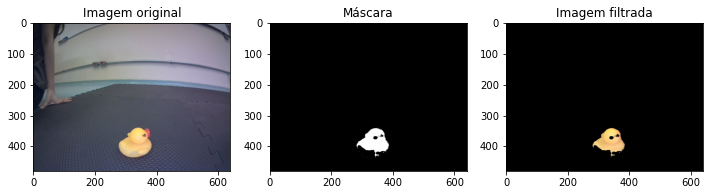

In [38]:
# Mais imagens reais de patos (note a distorção da lente de olho de peixe)
img_real = cv2.cvtColor(cv2.imread('img/patoperto.jpeg'), cv2.COLOR_BGR2RGB)
hsv_real = cv2.cvtColor(img_real, cv2.COLOR_RGB2HSV)
mask_real = cv2.inRange(hsv_real, lower_hsv, upper_hsv)
masked_real = cv2.bitwise_and(img_real, img_real, mask=mask_real)
f, ax = plt.subplots(1,3, figsize=(12,5))
ax[0].imshow(img_real);
ax[0].set_title('Imagem original');
ax[1].imshow(mask_real, cmap='gray');
ax[1].set_title('Máscara');
ax[2].imshow(masked_real);
ax[2].set_title('Imagem filtrada');

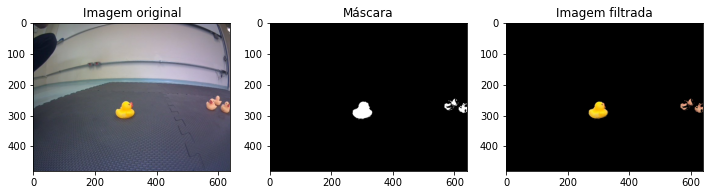

In [39]:
# Mais imagens reais de patos
img_real = cv2.cvtColor(cv2.imread('img/patomedio.jpeg'), cv2.COLOR_BGR2RGB)
hsv_real = cv2.cvtColor(img_real, cv2.COLOR_RGB2HSV)
mask_real = cv2.inRange(hsv_real, lower_hsv, upper_hsv)
masked_real = cv2.bitwise_and(img_real, img_real, mask=mask_real)
f, ax = plt.subplots(1,3, figsize=(12,5))
ax[0].imshow(img_real);
ax[0].set_title('Imagem original');
ax[1].imshow(mask_real, cmap='gray');
ax[1].set_title('Máscara');
ax[2].imshow(masked_real);
ax[2].set_title('Imagem filtrada');

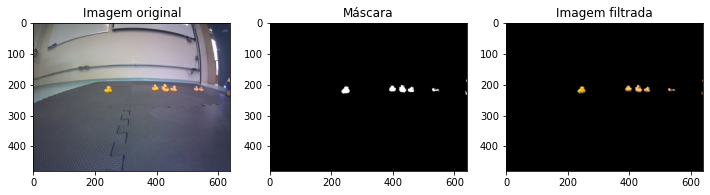

In [40]:
# Mais imagens reais de patos
img_real = cv2.cvtColor(cv2.imread('img/patolonge.jpeg'), cv2.COLOR_BGR2RGB)
hsv_real = cv2.cvtColor(img_real, cv2.COLOR_RGB2HSV)
mask_real = cv2.inRange(hsv_real, lower_hsv, upper_hsv)
masked_real = cv2.bitwise_and(img_real, img_real, mask=mask_real)
f, ax = plt.subplots(1,3, figsize=(12,5))
ax[0].imshow(img_real);
ax[0].set_title('Imagem original');
ax[1].imshow(mask_real, cmap='gray');
ax[1].set_title('Máscara');
ax[2].imshow(masked_real);
ax[2].set_title('Imagem filtrada');

## 💡 Exercício: Segmentando marcações de pista

Escreva agora funções que identifiquem nas imagens abaixo as faixas brancas e amarelas na imagem (um para cada).

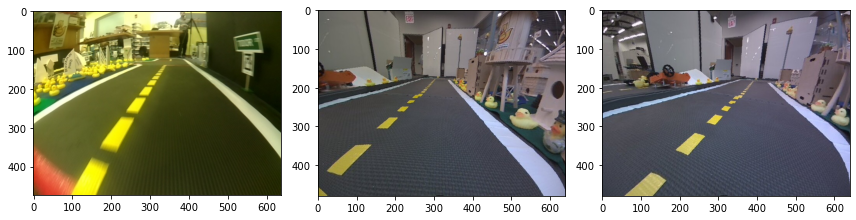

In [52]:
img_rgb = [
    cv2.imread('img/pista.jpg'), 
    cv2.imread('img/pista1.png'), 
    cv2.imread('img/pista2.png')
]

_, ax = plt.subplots(1,3,figsize=(12,5))

for i in range(3):
    ax[i].imshow( cv2.cvtColor(img_rgb[i], cv2.COLOR_BGR2RGB) )
plt.tight_layout()

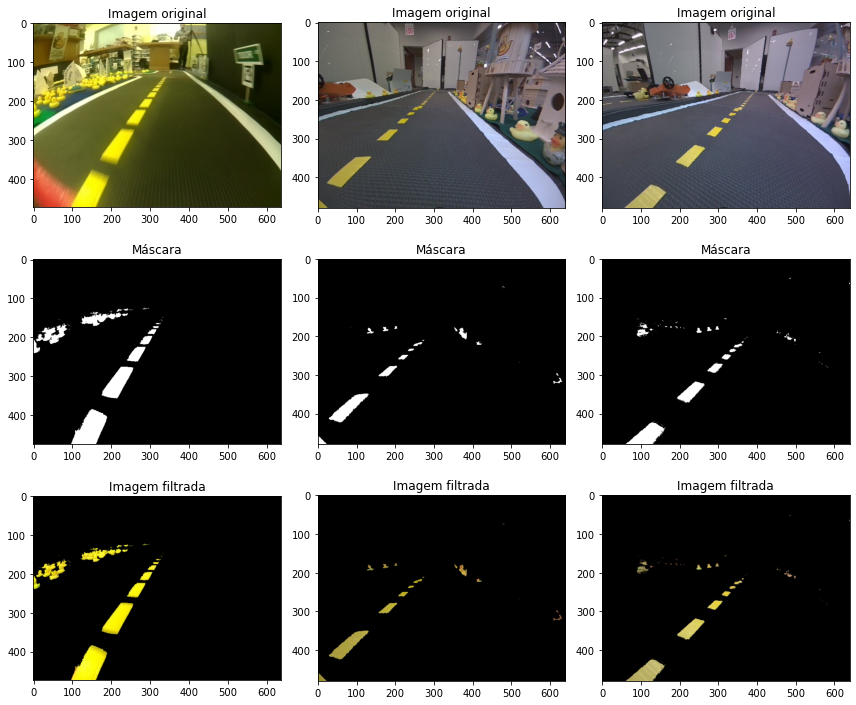

In [103]:
# Filtro para faixa tracejada central

mascaras = [
    [
        np.array([20, 180, 180]),
        np.array([100, 255, 255])
    ],
    [
        np.array([10, 130, 130]),
        np.array([100, 255, 255]),
    ],
    [
        np.array([10, 90, 90]),
        np.array([100, 255, 255]),
    ]
]

_, ax = plt.subplots(3,3,figsize=(12,10))
for i in range(3):
    img_hsv_a = cv2.cvtColor(img_rgb[i], cv2.COLOR_BGR2HSV)
    mascara_a = cv2.inRange(img_hsv_a, mascaras[i][0], mascaras[i][1])
    img_amarela = cv2.bitwise_and(img_rgb[i], img_rgb[i], mask=mascara_a)
    ax[0,i].imshow(cv2.cvtColor(img_rgb[i], cv2.COLOR_BGR2RGB))
    ax[0,i].set_title('Imagem original')
    ax[1,i].imshow(mascara_a, cmap='gray')
    ax[1,i].set_title('Máscara')
    ax[2,i].imshow(cv2.cvtColor(img_amarela, cv2.COLOR_BGR2RGB))
    ax[2,i].set_title('Imagem filtrada')
plt.tight_layout()

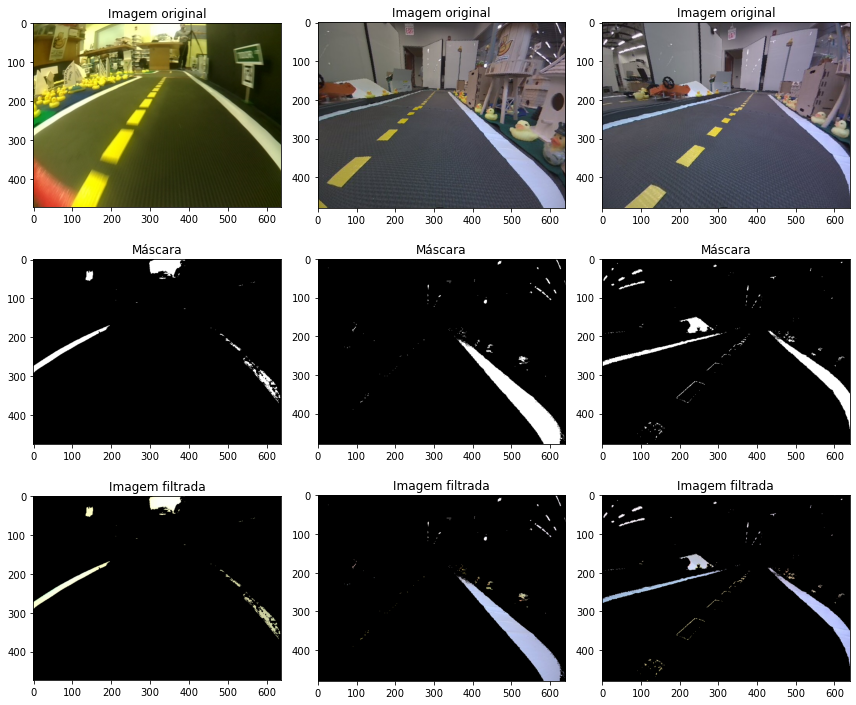

In [126]:
# Filtro para faixa contínua branca
mascaras = [
    [
        np.array([0, 0, 200]),
        np.array([179, 60, 255])
    ],
    [
        np.array([0, 0, 200]),
        np.array([179, 150, 255]),
    ],
    [
        np.array([0, 0, 200]),
        np.array([179, 100, 255]),
    ]
]

_, ax = plt.subplots(3,3,figsize=(12,10))
for i in range(3):
    img_hsv_b = cv2.cvtColor(img_rgb[i], cv2.COLOR_BGR2HSV)
    mascara_b = cv2.inRange(img_hsv_b, mascaras[i][0], mascaras[i][1])
    img_branco = cv2.bitwise_and(img_rgb[i], img_rgb[i], mask=mascara_b)
    ax[0,i].imshow(cv2.cvtColor(img_rgb[i], cv2.COLOR_BGR2RGB))
    ax[0,i].set_title('Imagem original')
    ax[1,i].imshow(mascara_b, cmap='gray')
    ax[1,i].set_title('Máscara')
    ax[2,i].imshow(cv2.cvtColor(img_branco, cv2.COLOR_BGR2RGB))
    ax[2,i].set_title('Imagem filtrada')
plt.tight_layout()